# HDA Final Project

## 1. Data Loading and Preprocessing

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
import h5py
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import random
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add, Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, ReLU, concatenate, MaxPooling2D, GlobalMaxPooling2D, Dropout
import tensorflow.keras.backend as K

In [24]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
# Function to list files in a folder and create a DataFrame
def create_dataframe(folder_path, label):
    file_list = os.listdir(folder_path)
    file_names = [os.path.join(os.path.basename(folder_path), file) for file in file_list]
    df = pd.DataFrame({'File': file_names, 'Label': label})
    return df

# Specify the paths to the folders
data_dir = 'data/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
normal_folder_path = os.path.join(data_dir, 'normal')
covid_folder_path = os.path.join(data_dir, 'covid')
pneumonia_folder_path = os.path.join(data_dir, 'pneumonia')

# Create DataFrames for each folder
normal_df = create_dataframe(normal_folder_path, label=0)
covid_df = create_dataframe(covid_folder_path, label=1)
pneumonia_df = create_dataframe(pneumonia_folder_path, label=2)

# Concatenate the DataFrames into a single DataFrame
reference_df = pd.concat([normal_df, covid_df, pneumonia_df], ignore_index=True)

# Display the DataFrame
print(reference_df.head())

                      File  Label
0  normal\00000002_000.png      0
1  normal\00000005_000.png      0
2  normal\00000005_003.png      0
3  normal\00000005_004.png      0
4  normal\00000005_005.png      0


In [26]:
# Enable smoke test
smoke_test = False
smoke_test_size = 96

train_reference_df, val_reference_df = train_test_split(reference_df, test_size=0.2, stratify=reference_df['Label'], random_state=123)

if smoke_test:
    train_reference_df = train_reference_df[:smoke_test_size]
    val_reference_df = val_reference_df[:smoke_test_size]

# Count the elements in the sets
num_train_data_normal = sum(train_reference_df['Label'] == 0)
num_train_data_covid   = sum(train_reference_df['Label'] == 1)
num_train_data_pneumonia   = sum(train_reference_df['Label'] == 2)
num_val_data_normal   = sum(val_reference_df['Label'] == 0)
num_val_data_covid     = sum(val_reference_df['Label'] == 1)
num_val_data_pneumonia   = sum(val_reference_df['Label'] == 2)

print('TRAIN SET')
print('\tNormal X-ray: {} ({:.2f}%)'.format(num_train_data_normal, 100 * num_train_data_normal / len(train_reference_df)))
print('\tCOVID-19 X-ray: {} ({:.2f}%)'.format(num_train_data_covid, 100 * num_train_data_covid / len(train_reference_df)))
print('\tPneumonia X-ray: {} ({:.2f}%)'.format(num_train_data_pneumonia, 100 * num_train_data_pneumonia / len(train_reference_df)))
print('VALIDATION SET')
print('\tNormal ECG: {} ({:.2f}%)'.format(num_val_data_normal, 100 * num_val_data_normal / len(val_reference_df)))
print('\tCOVID-19 X-ray: {} ({:.2f}%)'.format(num_val_data_covid, 100 * num_val_data_covid / len(val_reference_df)))
print('\tPneumonia X-ray: {} ({:.2f}%)'.format(num_val_data_pneumonia, 100 * num_val_data_pneumonia / len(val_reference_df)))

TRAIN SET
	Normal X-ray: 1220 (33.33%)
	COVID-19 X-ray: 1220 (33.33%)
	Pneumonia X-ray: 1220 (33.33%)
VALIDATION SET
	Normal ECG: 305 (33.33%)
	COVID-19 X-ray: 305 (33.33%)
	Pneumonia X-ray: 305 (33.33%)


Text(0.5, 1.0, 'pneumonia/00013304_002.png - pneumonia X-ray')

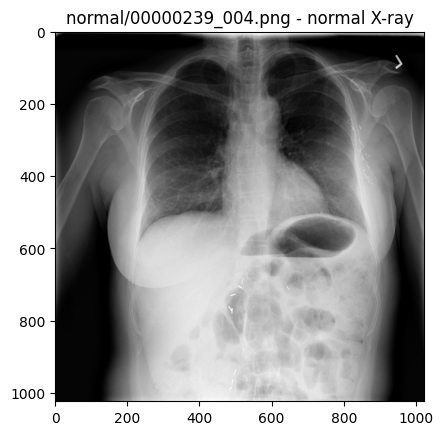

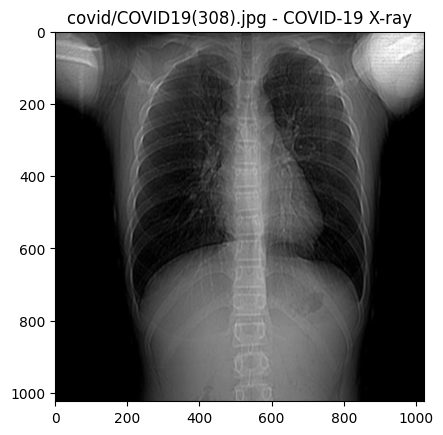

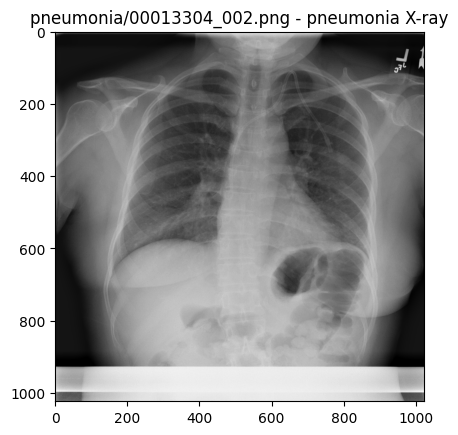

In [27]:
def load_image(file_name, data_dir):
    if isinstance(data_dir, bytes):
        data_dir = data_dir.decode()
    if isinstance(file_name, bytes):
        file_name = file_name.decode()

    # Load the image
    file_path = os.path.join(data_dir, file_name)
    image = Image.open(file_path)

    # Convert RGBA to L (grayscale)
    image = image.convert('L')

    return image

# Examples
data_dir = 'data/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'

# Plot a normal chest X-ray
file_name = 'normal/00000239_004.png'

normal_image = load_image(file_name, data_dir)

plt.figure()
plt.imshow(normal_image, cmap='gray')
plt.title('{} - normal X-ray'.format(file_name))

# Plot a COVID-19 chest X-ray
file_name = 'covid/COVID19(308).jpg'

covid_image = load_image(file_name, data_dir)

plt.figure()
plt.imshow(covid_image, cmap='gray')
plt.title('{} - COVID-19 X-ray'.format(file_name))

# Plot a pneumonia chest X-ray
file_name = 'pneumonia/00013304_002.png'

pneumonia_image = load_image(file_name, data_dir)

plt.figure()
plt.imshow(pneumonia_image, cmap='gray')
plt.title('{} - pneumonia X-ray'.format(file_name))

In [28]:
for name in list(train_reference_df.File[:10]):
    data = load_image(name.encode(), data_dir)
    print('File: {} - Size: {}'.format(name, data.size))

File: pneumonia\person351_bacteria_1621.jpeg - Size: (928, 824)
File: pneumonia\00005892_001.png - Size: (1024, 1024)
File: covid\COVID19(281).jpg - Size: (895, 734)
File: pneumonia\person741_virus_1364.jpeg - Size: (984, 552)
File: normal\00000073_007.png - Size: (1024, 1024)
File: normal\00000142_000.png - Size: (1024, 1024)
File: normal\00000521_000.png - Size: (1024, 1024)
File: covid\COVID-19 (722).jpg - Size: (1024, 1024)
File: pneumonia\person336_bacteria_1549.jpeg - Size: (968, 752)
File: covid\COVID-19 (682).jpg - Size: (1024, 1024)


Text(0.5, 1.0, 'pneumonia/person66_bacteria_323.jpeg - processed')

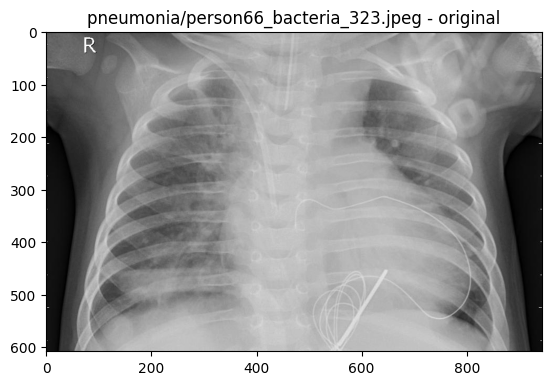

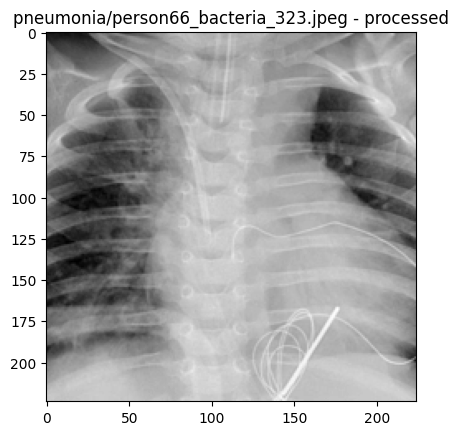

In [29]:
def center_crop_and_resize(image, target_size=(224, 224), center_crop=True):

    if center_crop:
        # Get the original size of the image
        original_width, original_height = image.size
    
        # Calculate the crop box coordinates to achieve an even aspect ratio
        aspect_ratio = target_size[0] / target_size[1]
        crop_width = min(original_width, int(original_height * aspect_ratio))
        crop_left = max(0, (original_width - crop_width) // 2)
        crop_right = min(original_width, crop_left + crop_width)
    
        # Perform the center crop
        image = image.crop((crop_left, 0, crop_right, original_height))

    # Resize the cropped image to the target size
    processed_image = image.resize(target_size)

    return processed_image

# Example usage
file_name = 'pneumonia/person66_bacteria_323.jpeg'
original_image = load_image(file_name, data_dir)

plt.figure()
plt.imshow(original_image, cmap='gray')
plt.title('{} - original'.format(file_name))

target_size = (224, 224)

# Process the image (center crop and resize)
processed_image = center_crop_and_resize(original_image, target_size)

plt.figure()
plt.imshow(processed_image, cmap='gray')
plt.title('{} - processed'.format(file_name))

In [30]:
def normalize_image(image, new_range=(0,1)):
    # Convert PIL image to NumPy array
    img_array = np.array(image)

    # Scale pixel values to the new range
    new_min, new_max = new_range
    scaled_array = (img_array / 255) * (new_max - new_min) + new_min

    # Clip values to ensure they are within the specified range
    scaled_array = np.clip(scaled_array, new_range[0], new_range[1])

    return scaled_array

# Example usage:
file_name = 'pneumonia/person66_bacteria_323.jpeg'
original_image = load_image(file_name, data_dir)
target_size = (224, 224)
# Process the image (center crop and resize)
processed_image = center_crop_and_resize(original_image, target_size)
# Scale the pixel values to the new range
print(np.array(processed_image))
new_range = (0,1)
scaled_image = normalize_image(processed_image, new_range)
print(scaled_image)
print(scaled_image.shape)

[[ 82  81  81 ... 162 155 148]
 [ 84  83  82 ... 162 160 159]
 [ 88  87  87 ... 162 165 169]
 ...
 [191 192 192 ... 193 191 191]
 [192 192 192 ... 197 194 194]
 [193 193 193 ... 197 195 195]]
[[0.32156863 0.31764706 0.31764706 ... 0.63529412 0.60784314 0.58039216]
 [0.32941176 0.3254902  0.32156863 ... 0.63529412 0.62745098 0.62352941]
 [0.34509804 0.34117647 0.34117647 ... 0.63529412 0.64705882 0.6627451 ]
 ...
 [0.74901961 0.75294118 0.75294118 ... 0.75686275 0.74901961 0.74901961]
 [0.75294118 0.75294118 0.75294118 ... 0.77254902 0.76078431 0.76078431]
 [0.75686275 0.75686275 0.75686275 ... 0.77254902 0.76470588 0.76470588]]
(224, 224)


In [31]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y].T
    return Y

print(train_reference_df['Label'])
one_hot = convert_to_one_hot(train_reference_df['Label'], 3).T
print(one_hot)

3966    2
3087    2
2671    1
4421    2
81      0
       ..
1585    1
976     0
1541    1
838     0
1490    0
Name: Label, Length: 3660, dtype: int64
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## 2. Data Loading Using the Dataset API

In [32]:
def load_and_preprocess_data(file_name, data_dir):
    # Load data
    data = load_image(file_name, data_dir)
    # Baseline wander removal
    data = center_crop_and_resize(data, target_size=(224,224))
    # Normalize
    data = normalize_image(data, new_range=(0,1))
    return data.astype(np.float32)

# Example
file_name = 'pneumonia/person66_bacteria_323.jpeg'
data = load_and_preprocess_data(file_name, data_dir)

print(data)

[[0.32156864 0.31764707 0.31764707 ... 0.63529414 0.60784316 0.5803922 ]
 [0.32941177 0.3254902  0.32156864 ... 0.63529414 0.627451   0.62352943]
 [0.34509805 0.34117648 0.34117648 ... 0.63529414 0.64705884 0.6627451 ]
 ...
 [0.7490196  0.7529412  0.7529412  ... 0.75686276 0.7490196  0.7490196 ]
 [0.7529412  0.7529412  0.7529412  ... 0.77254903 0.7607843  0.7607843 ]
 [0.75686276 0.75686276 0.75686276 ... 0.77254903 0.7647059  0.7647059 ]]


In [33]:
def create_dataset(reference_df, batch_size, shuffle, cache_file=None):
    # Convert dataframe to lists
    file_names = list(reference_df['File'])
    labels = reference_df['Label']
    # One Hot
    labels = convert_to_one_hot(labels, 3).T

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.numpy_function(load_and_preprocess_data, [file_name, data_dir],
                                                             tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, -1), label))

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [34]:
#batch_size = 4
batch_size = 32
train_dataset = create_dataset(train_reference_df,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file=None)
#cache_file='train_cache'

val_dataset = create_dataset(val_reference_df,
                             batch_size=batch_size,
                             shuffle=False,
                             cache_file=None)

#cache_file='val_cache'

train_steps = int(np.ceil(len(train_reference_df)/batch_size))
val_steps = int(np.ceil(len(val_reference_df)/batch_size))

In [13]:
# Inspect the first entry of the training dataset
for img1, labels in train_dataset.take(1):
    print("Data shape:", img1.shape)
    print("First entry data:", img1[0])
    print("Label shape:", labels.shape)
    print("Labels:", labels[0])

Data shape: (4, 224, 224, 1)
First entry data: tf.Tensor(
[[[0.59607846]
  [0.59607846]
  [0.6039216 ]
  ...
  [0.6666667 ]
  [0.6745098 ]
  [0.65882355]]

 [[0.6039216 ]
  [0.6039216 ]
  [0.6117647 ]
  ...
  [0.6627451 ]
  [0.6627451 ]
  [0.67058825]]

 [[0.6       ]
  [0.6       ]
  [0.60784316]
  ...
  [0.6666667 ]
  [0.67058825]
  [0.67058825]]

 ...

 [[0.70980394]
  [0.7058824 ]
  [0.7058824 ]
  ...
  [0.43529412]
  [0.43137255]
  [0.43137255]]

 [[0.7137255 ]
  [0.7058824 ]
  [0.7019608 ]
  ...
  [0.43137255]
  [0.42745098]
  [0.42352942]]

 [[0.70980394]
  [0.7137255 ]
  [0.70980394]
  ...
  [0.42352942]
  [0.42352942]
  [0.42745098]]], shape=(224, 224, 1), dtype=float32)
Label shape: (4, 3)
Labels: tf.Tensor([0. 0. 1.], shape=(3,), dtype=float64)


## Model Definition

### Autoencoder

In [51]:
def create_dataset_autoencoder(reference_df, batch_size, shuffle, cache_file=None):
    # Convert dataframe to lists
    file_names = list(reference_df['File'])

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names))

    # Map the load_and_preprocess_data function
    py_func = lambda file_name: (tf.numpy_function(load_and_preprocess_data, [file_name, data_dir],
                                                             tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Correct input shape
    dataset = dataset.map(lambda data: (tf.expand_dims(data, -1)))
    
    # Duplicate data for the autoencoder (input = output)
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct)
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [52]:
batch_size = 32
train_dataset_autoencoder = create_dataset_autoencoder(train_reference_df,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file=None)
#cache_file='train_cache'

val_dataset_autoencoder = create_dataset_autoencoder(val_reference_df,
                             batch_size=batch_size,
                             shuffle=False,
                             cache_file=None)

#cache_file='val_cache'

train_steps = int(np.ceil(len(train_reference_df)/batch_size))
val_steps = int(np.ceil(len(val_reference_df)/batch_size))

In [53]:
# Inspect the first entry of the training dataset
for img1, img2 in train_dataset_autoencoder.take(1):
    print("Data shape:", img1.shape)
    print("First entry data:", img1[0])
    print("Duplicated image:", img2[0])

Data shape: (32, 224, 224, 1)
First entry data: tf.Tensor(
[[[0.3254902 ]
  [0.34509805]
  [0.3529412 ]
  ...
  [0.30588236]
  [0.3019608 ]
  [0.30588236]]

 [[0.32156864]
  [0.3254902 ]
  [0.34117648]
  ...
  [0.30588236]
  [0.3019608 ]
  [0.30588236]]

 [[0.4       ]
  [0.50980395]
  [0.5176471 ]
  ...
  [0.30980393]
  [0.31764707]
  [0.30588236]]

 ...

 [[0.        ]
  [0.        ]
  [0.00784314]
  ...
  [0.        ]
  [0.        ]
  [0.00392157]]

 [[0.        ]
  [0.        ]
  [0.00784314]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.00784314]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]], shape=(224, 224, 1), dtype=float32)
Duplicated image: tf.Tensor(
[[[0.3254902 ]
  [0.34509805]
  [0.3529412 ]
  ...
  [0.30588236]
  [0.3019608 ]
  [0.30588236]]

 [[0.32156864]
  [0.3254902 ]
  [0.34117648]
  ...
  [0.30588236]
  [0.3019608 ]
  [0.30588236]]

 [[0.4       ]
  [0.50980395]
  [0.5176471 ]
  ...
  [0.30980393]
  [0.31764707]
  [0

In [54]:
# FUNCTION: define a convolutional autoencoder as described above

def build_deep_autoencoder(img_shape, code_size):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the size of the hidden representation of the input (code)

    Returns:
    encoder -- keras model for the encoder network
    decoder -- keras model for the decoder network
    """

    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))

    encoder.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))
    
    encoder.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(layers.Dense(14 * 14 * 256, activation='elu'))
    decoder.add(layers.Reshape((14, 14, 256)))
    decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, activation=None, padding='same'))

    return encoder, decoder

In [55]:
# Look at encoder and decoder shapes. The total number of trainable parameters of encoder and decoder should be close
IMG_SHAPE = (224, 224, 1)
CODE_SIZE = 64
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=CODE_SIZE)
encoder.summary()
decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 28, 28, 128)     

In [56]:
inp = tf.keras.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

# create the autoencoder model: use tf.keras.Model() with the correct input and output tensors from the line above
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)

autoencoder.compile(optimizer="adamax", loss='mse')

In [57]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

history = autoencoder.fit(train_dataset_autoencoder, epochs=30,
                          steps_per_epoch=train_steps,
                          validation_data=val_dataset_autoencoder,
                          validation_steps=val_steps,
                          callbacks=[early_stop_callback])

Epoch 1/30
115/115 [==============================] - 25s 135ms/step - loss: 0.0499 - val_loss: 0.0174
Epoch 2/30
115/115 [==============================] - 16s 137ms/step - loss: 0.0145 - val_loss: 0.0127
Epoch 3/30
115/115 [==============================] - 16s 139ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 4/30
115/115 [==============================] - 16s 136ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 5/30
115/115 [==============================] - 15s 133ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 6/30
115/115 [==============================] - 16s 137ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 7/30
115/115 [==============================] - 15s 132ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 8/30
115/115 [==============================] - 15s 134ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 9/30
115/115 [==============================] - 17s 144ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 10/30
115/115 [==============================] - 16s 144ms/step - l

In [58]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [40]:
# restore trained weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=CODE_SIZE)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = tf.keras.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [59]:
def show_image(x):
    plt.imshow(x, cmap='gray')

In [60]:
# FUNCTION: draws original, encoded and decoded images

def visualize(img, encoder, decoder):
    """
    Arguments:
    img -- original image
    encoder -- trained encoder network
    decoder -- trained decoder network
    """

    code = encoder.predict(img[np.newaxis, :])[0]  # img[np.newaxis, :] is used to add an additional axis
                                                   # Remeber that the model takes as input a 4-dimensional array (?, height, width, channels) where the first dimension
                                                   # is the one related to the mini-batch size. Here our "mini-batch" is composed of a single image
    reco = decoder.predict(code[None])[0]  # img[None] is the same as img[np.newaxis, :]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]), cmap='gray')

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


1/1 [==============================] - 0s 87ms/step


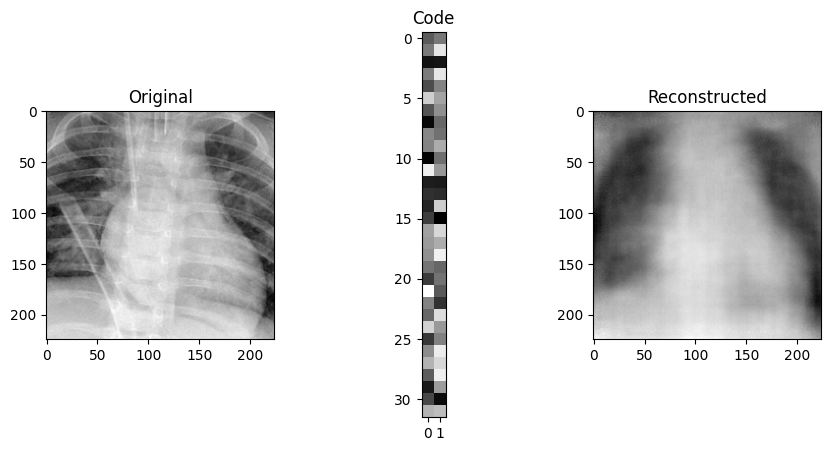

1/1 [==============================] - 0s 18ms/step


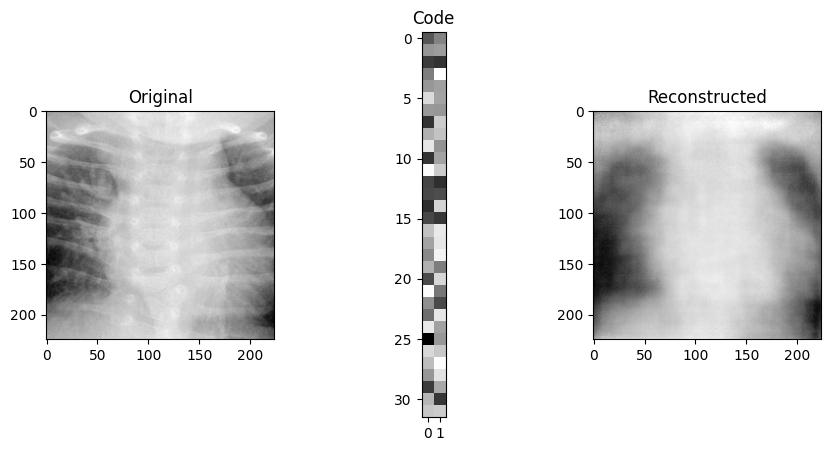

1/1 [==============================] - 0s 19ms/step


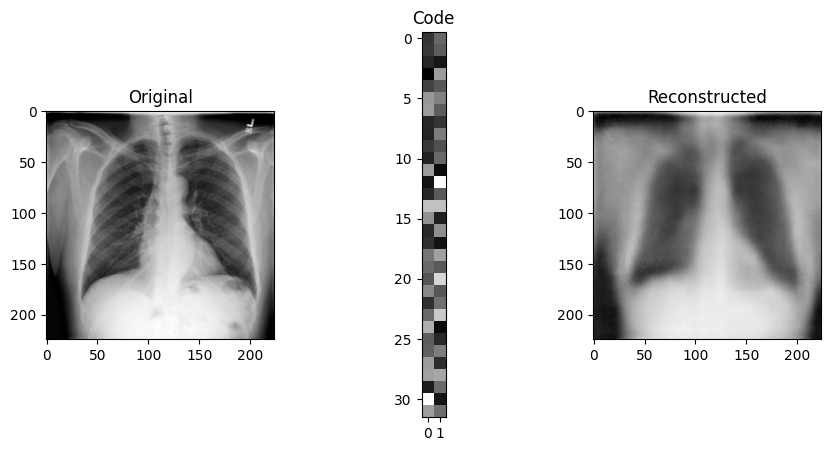

1/1 [==============================] - 0s 20ms/step


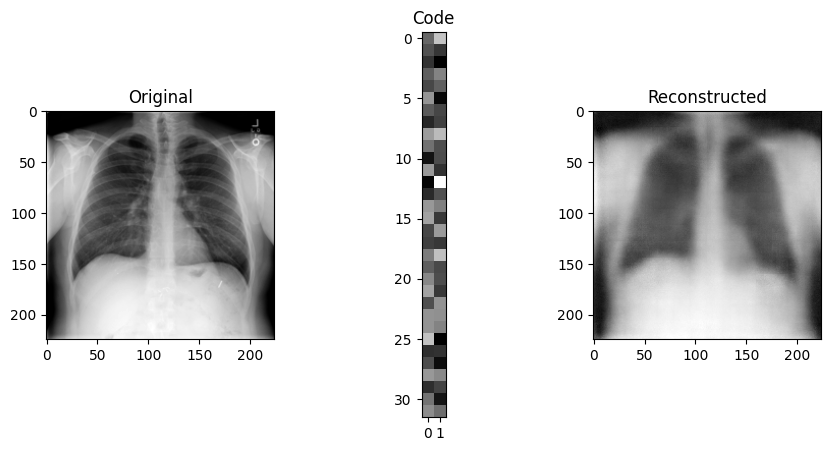

1/1 [==============================] - 0s 18ms/step


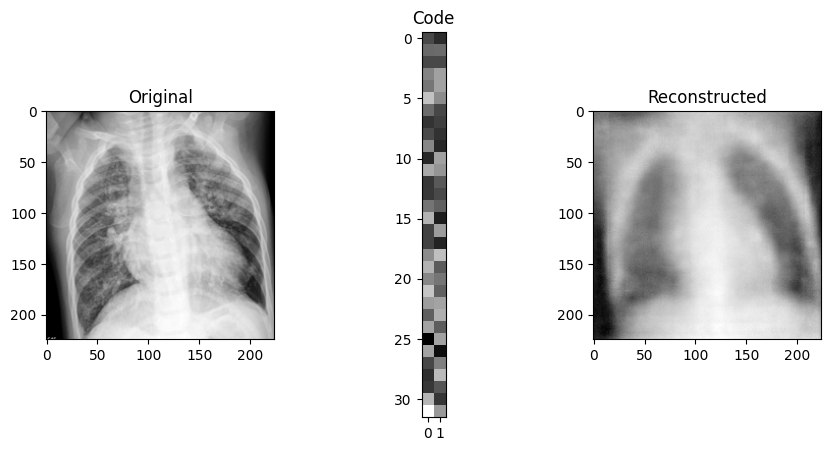

In [61]:
#reconstruction_mse = autoencoder.evaluate(val_dataset, steps=val_steps, verbose=0)
#print("Convolutional autoencoder MSE:", reconstruction_mse)

# Select random images from the validation dataset and visualize
for i in range(5):
    idx = random.randint(0, len(val_reference_df) - 1)
    file = val_reference_df.iloc[idx]['File']
    img = load_and_preprocess_data(file, data_dir)
    plt.figure(figsize=(10, 5))
    visualize(img, encoder, decoder)
    plt.show()

In [62]:
def dense_model(code_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(code_size,)))  # Define input shape directly
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    return model


In [63]:
# Load pre-trained weights into the encoder
#encoder.load_weights("encoder_weights.h5")

# Disable training for the encoder
encoder.trainable = False

# Use encoder to obtain encoded features
encoded_features = encoder(inp)

# Continue with your classification model as before
label = dense_model(CODE_SIZE)(encoded_features)
classifier_model = Model(inp, label)
classifier_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [64]:
# Train the model
num_epochs = 30

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

# Fit the model
history = classifier_model.fit(train_dataset, epochs=num_epochs,
                    steps_per_epoch=train_steps,
                    validation_data=val_dataset,
                    validation_steps=val_steps,
                    callbacks=[early_stop_callback])

Epoch 1/30
115/115 [==============================] - 26s 127ms/step - loss: 0.7568 - accuracy: 0.7777 - val_loss: 0.4578 - val_accuracy: 0.8556
Epoch 2/30
115/115 [==============================] - 13s 118ms/step - loss: 0.3394 - accuracy: 0.8829 - val_loss: 0.3880 - val_accuracy: 0.8804
Epoch 3/30
115/115 [==============================] - 13s 118ms/step - loss: 0.2553 - accuracy: 0.9166 - val_loss: 0.3413 - val_accuracy: 0.8772
Epoch 4/30
115/115 [==============================] - 14s 119ms/step - loss: 0.2108 - accuracy: 0.9318 - val_loss: 0.3731 - val_accuracy: 0.8578
Epoch 5/30
115/115 [==============================] - 13s 118ms/step - loss: 0.1705 - accuracy: 0.9481 - val_loss: 0.3178 - val_accuracy: 0.8976
Epoch 6/30
115/115 [==============================] - 14s 119ms/step - loss: 0.1504 - accuracy: 0.9497 - val_loss: 0.3208 - val_accuracy: 0.8976
Epoch 7/30
115/115 [==============================] - 14s 125ms/step - loss: 0.1181 - accuracy: 0.9620 - val_loss: 0.3143 - val_ac

In [65]:
# Save the model
classifier_model.save('encoder_classifier.h5')

In [66]:
# Assuming 'encoder' is your original encoder model
encoder_copy = tf.keras.models.clone_model(encoder)

# Disable training for the encoder
encoder_copy.trainable = True

# Use encoder to obtain encoded features
encoded_features = encoder_copy(inp)

# Continue with your classification model as before
label = dense_model(CODE_SIZE)(encoded_features)
classifier_model = tf.keras.Model(inputs=inp, outputs=label)
classifier_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [67]:
# Train the model
num_epochs = 30

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

# Fit the model
history = classifier_model.fit(train_dataset, epochs=num_epochs,
                    steps_per_epoch=train_steps,
                    validation_data=val_dataset,
                    validation_steps=val_steps,
                    callbacks=[early_stop_callback])

Epoch 1/30
115/115 [==============================] - 26s 129ms/step - loss: 0.8671 - accuracy: 0.6639 - val_loss: 0.4430 - val_accuracy: 0.8481
Epoch 2/30
115/115 [==============================] - 14s 122ms/step - loss: 0.3867 - accuracy: 0.8701 - val_loss: 0.3202 - val_accuracy: 0.9041
Epoch 3/30
115/115 [==============================] - 14s 124ms/step - loss: 0.3156 - accuracy: 0.8918 - val_loss: 0.2724 - val_accuracy: 0.9127
Epoch 4/30
115/115 [==============================] - 14s 125ms/step - loss: 0.2466 - accuracy: 0.9212 - val_loss: 0.2662 - val_accuracy: 0.9159
Epoch 5/30
115/115 [==============================] - 14s 124ms/step - loss: 0.2232 - accuracy: 0.9258 - val_loss: 0.2668 - val_accuracy: 0.9192
Epoch 6/30
115/115 [==============================] - 14s 126ms/step - loss: 0.1841 - accuracy: 0.9359 - val_loss: 0.2388 - val_accuracy: 0.9203
Epoch 7/30
115/115 [==============================] - 15s 128ms/step - loss: 0.1727 - accuracy: 0.9408 - val_loss: 0.2406 - val_ac

In [68]:
# Save the model
classifier_model.save('encoder_classifier_retrained.h5')

### Inception V4

In [14]:
def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None,
              name=None):

    conv_name_base = 'conv_'
    bn_name_base = 'bn_'

    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides,
               padding = padding, name = conv_name_base + name,
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = bn_name_base + name)(X)
    if activation is not None:
        X = Activation(activation)(X)
        
    return X

In [15]:
def stem_block(X_input):

    # First conv
    X = conv2d_bn(X_input, filters = 32, kernel_size = (3, 3), strides = (2, 2),
                  padding = 'valid', activation='relu', name = 'stem_1th')

    # Second conv
    X = conv2d_bn(X, filters = 32, kernel_size = (3, 3), strides = (1, 1),
                  padding = 'valid', activation='relu', name = 'stem_2nd')

    # Third conv
    X = conv2d_bn(X, filters = 64, kernel_size = (3, 3), strides = (1, 1),
                  padding = 'same', activation='relu', name =  'stem_3rd')

    # First branch: max pooling
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_1stbranch_1')(X)

    # Second branch: conv
    branch2 = conv2d_bn(X, filters = 96, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'stem_1stbranch_2')

    # Concatenate (1) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    # First branch: 2 convs
    branch1 = conv2d_bn(X, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_1_1')
    branch1 = conv2d_bn(branch1, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'valid', activation='relu',
                        name = 'stem_2ndbranch_1_2')

    # Second branch: 4 convs
    branch2 = conv2d_bn(X, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_1')
    branch2 = conv2d_bn(branch2, filters = 64, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_2')
    branch2 = conv2d_bn(branch2, filters = 64, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_3')
    branch2 = conv2d_bn(branch2, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'valid', activation='relu',
                        name = 'stem_2ndbranch_2_4')

    # Concatenate (2) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    # First branch: conv
    branch1 = conv2d_bn(X, filters = 192, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'stem_3rdbranch_1')

    # Second branch: max pooling
    branch2 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_3rdbranch_2')(X)

    # Concatenate (3) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)
    
    return X

In [16]:
def inception_a_block(X_input, base_name):

    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ia_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 96, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 96, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_3_2')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_3')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)

    return X

In [17]:
def inception_b_block(X_input, base_name):

    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ib_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 128, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 224, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_3')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 192, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 224, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_3')
    branch4 = conv2d_bn(branch4, filters = 224, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_4')
    branch4 = conv2d_bn(branch4, filters = 256, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_5')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)

    return X

In [18]:
def inception_c_block(X_input, base_name):

    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ic_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_1')
    branch3_1 = conv2d_bn(branch3, filters = 256, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_2')
    branch3_2 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_3')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 448, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 512, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_3')
    branch4_1 = conv2d_bn(branch4, filters = 256, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_4')
    branch4_2 = conv2d_bn(branch4, filters = 256, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_5')

    # Concatenate branch1, branch2, branch3_1, branch3_2, branch4_1 and branch4_2 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3_1, branch3_2, branch4_1,
                          branch4_2], axis=3)
    return X

In [19]:
def reduction_a_block(X_input):

    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'ra_branch_1_1')(X_input)

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 384, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'ra_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'ra_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 224, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'ra_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'ra_branch_3_3')

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3], axis=3)

    return X

In [20]:
def reduction_b_block(X_input):

    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'rb_branch_1_1')(X_input)

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_2_1')
    branch2 = conv2d_bn(branch2, filters = 192, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'rb_branch_2_2')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 320, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_3')
    branch3 = conv2d_bn(branch3, filters = 320, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'rb_branch_3_4')

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3], axis=3)

    return X

In [21]:
def Inceptionv4(input_shape):

    # Define the input as a tensor with shape input_shape (1 line)
    X_input = Input(input_shape)

    # Call the above functions for the stem, inception-a, reduction-a, inception-b, reduction-b and inception-c blocks
    X = stem_block(X_input)

    # Four Inception A blocks
    X = inception_a_block(X, 'a1')
    X = inception_a_block(X, 'a2')
    X = inception_a_block(X, 'a3')
    X = inception_a_block(X, 'a4')

    # Reduction A block
    X = reduction_a_block(X)

    # Seven Inception B blocks
    X = inception_b_block(X, 'b1')
    X = inception_b_block(X, 'b2')
    X = inception_b_block(X, 'b3')
    X = inception_b_block(X, 'b4')
    X = inception_b_block(X, 'b5')
    X = inception_b_block(X, 'b6')
    X = inception_b_block(X, 'b7')

    # Reduction B block
    X = reduction_b_block(X)

    # Three Inception C blocks
    X = inception_c_block(X, 'c1')
    X = inception_c_block(X, 'c2')
    X = inception_c_block(X, 'c3')

    # AVGPOOL (1 line). Use "X = AveragePooling2D(...)(X)"
    kernel_pooling = X.get_shape()[1:3]
    X = AveragePooling2D(kernel_pooling, name='avg_pool')(X)
    X = Flatten()(X)

    # Dropout
    X = Dropout(rate = 0.2)(X)

    # Output layer
    X = Dense(3, activation='softmax', name='fc')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='Inceptionv4')

    return model

In [22]:
network_model_inception = Inceptionv4(input_shape = (224, 224, 1))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)

# Compile the model
network_model_inception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### DenseNet

In [14]:
def densenet(input_shape, n_classes, filters=16, dropout_rate=0.2):

    def bn_rl_conv(x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding='same')(x)
        return x
    
    def dense_block(x, repetition):
        for _ in range(repetition):
            y = bn_rl_conv(x, 4 * filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y, x])
        return x
        
    def transition_layer(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x
    
    input = Input(input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    for repetition in [6, 12, 24, 16]:
        d = dense_block(x, repetition)
        x = Dropout(dropout_rate)(d)
        x = transition_layer(d)
        
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation='softmax')(x)
    
    model = Model(input, output)
    return model

In [15]:
dense_net_model = densenet((224, 224, 1), n_classes=3)

adam_optimizer = Adam(learning_rate=0.001)

dense_net_model.compile(optimizer = adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Model Training and Testing

In [16]:
# Train the model
num_epochs = 50

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

# Fit the model
history = dense_net_model.fit(train_dataset, epochs=num_epochs,
                    steps_per_epoch=train_steps,
                    validation_data=val_dataset,
                    validation_steps=val_steps)

# Save the model
dense_net_model.save('dense.h5')

Epoch 1/50
915/915 [==============================] - 93s 78ms/step - loss: 0.8578 - accuracy: 0.6563 - val_loss: 1.5359 - val_accuracy: 0.6092
Epoch 2/50
915/915 [==============================] - 69s 76ms/step - loss: 0.5116 - accuracy: 0.8126 - val_loss: 8.1418 - val_accuracy: 0.3330
Epoch 3/50
915/915 [==============================] - 68s 75ms/step - loss: 0.4072 - accuracy: 0.8522 - val_loss: 1.3003 - val_accuracy: 0.5873
Epoch 4/50
915/915 [==============================] - 70s 76ms/step - loss: 0.3488 - accuracy: 0.8839 - val_loss: 5.6816 - val_accuracy: 0.3330
Epoch 5/50
915/915 [==============================] - 72s 79ms/step - loss: 0.3173 - accuracy: 0.8956 - val_loss: 0.9949 - val_accuracy: 0.7249
Epoch 6/50
915/915 [==============================] - 72s 78ms/step - loss: 0.2871 - accuracy: 0.9063 - val_loss: 0.4990 - val_accuracy: 0.8679
Epoch 7/50
915/915 [==============================] - 70s 76ms/step - loss: 0.2741 - accuracy: 0.9087 - val_loss: 2.0811 - val_accuracy:

Text(0, 0.5, 'Accuracy')

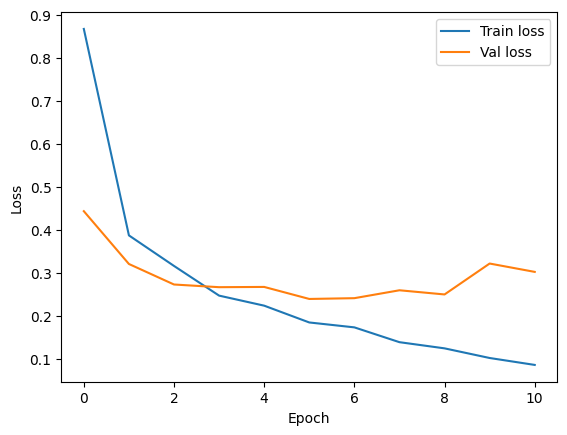

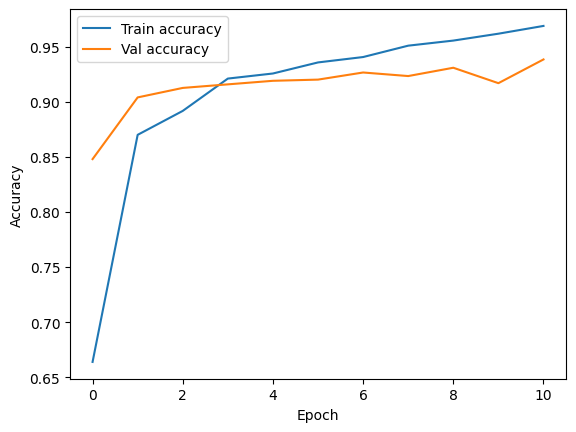

In [69]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')